In [2]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

In [3]:
dataset = pd.read_csv('D:/finance-vix.txt',
                     sep=',',
                     parse_dates=[0],
                     infer_datetime_format=True,
                     index_col=False,
                     na_values=['nan', '?'])

#Fill na values with 0
dataset.fillna(0, inplace=True)
display(dataset.head())

#Separate 'Date' from dataframe and convert to 'to_datetime'
date_col = dataset['Date'] 
date_col = pd.to_datetime(date_col)

#Drop date from dataset
dataset = dataset.drop('Date', axis=1)

#variable for training
values = dataset.values
values = values.astype('float32')

,Date,VIX Open,VIX High,VIX Low,VIX Close
0,2004-01-02,17.96,18.68,17.54,18.22
1,2004-01-05,18.45,18.49,17.44,17.49
2,2004-01-06,17.66,17.67,16.19,16.73
3,2004-01-07,16.72,16.75,15.50,15.50
4,2004-01-08,15.42,15.68,15.32,15.61


In [4]:
#All variables without 'Date'
dataset.head()

,VIX Open,VIX High,VIX Low,VIX Close
0,17.96,18.68,17.54,18.22
1,18.45,18.49,17.44,17.49
2,17.66,17.67,16.19,16.73
3,16.72,16.75,15.50,15.50
4,15.42,15.68,15.32,15.61


<AxesSubplot:>

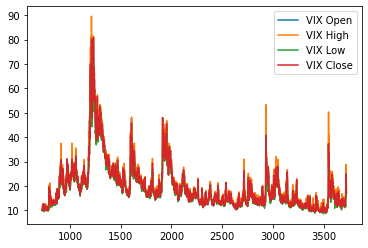

In [5]:
#Plotting values
values_plot = dataset.tail(3000)
values_plot.plot.line()

In [6]:
#Because of using tanh and sigmoid in LSTM that are sensitive to magnitade, values have to be normalized
#Normalizing variables
scaler = StandardScaler()
scaler = scaler.fit(values)
values_scaled = scaler.transform(values)
scaled = pd.DataFrame(values_scaled)

In [7]:
scaled.head()

,0,1,2,3
0,-0.056011,-0.065623,-0.008681,-0.015599
1,-0.000821,-0.085699,-0.020774,-0.098144
2,-0.089800,-0.172342,-0.171944,-0.184082
3,-0.195675,-0.269552,-0.255389,-0.323165
4,-0.342097,-0.382612,-0.277158,-0.310727


In [8]:
#For LSTM network, input data should be shaped into n_sample * timesteps
# In this case, n_features is 2. we will make timesteps= 3
# So, n_samples is equal to 5

x_train = []   #training series
y_train = []   #prediction

#Number of days that we want to predict to the future
num_future = 1
#Number of past days that we plan to predict the future based on it
num_past = 15

for i in range(num_past, len(values) - num_future + 1):
    x_train.append(values_scaled[i - num_past:i, 0:values.shape[1]])
    y_train.append(values_scaled[i + num_future - 1:i + num_future, 0])
    
X_train, Y_train = np.array(x_train), np.array(y_train)

#Print train X and Y shape
print("X_train shape is: {}".format(X_train.shape))
print("Y_train shape is: {}".format(Y_train.shape))

X_train shape is: (3710, 15, 4)
Y_train shape is: (3710, 1)


## Set LSTM model

In [11]:
model = Sequential()
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))

#Compile the model
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 64)            17664     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [12]:
#fit the model
history_lstm = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)


Train on 3339 samples, validate on 371 samples
Epoch 1/15
3339/3339 [==============================] - 7s 2ms/step - loss: 0.2836 - val_loss: 0.0626
Epoch 2/15
3339/3339 [==============================] - 4s 1ms/step - loss: 0.1100 - val_loss: 0.0446
Epoch 3/15
3339/3339 [==============================] - 5s 1ms/step - loss: 0.0895 - val_loss: 0.0364
Epoch 4/15
3339/3339 [==============================] - 4s 1ms/step - loss: 0.0669 - val_loss: 0.0298
Epoch 5/15
3339/3339 [==============================] - 5s 1ms/step - loss: 0.0619 - val_loss: 0.0278
Epoch 6/15
3339/3339 [==============================] - 5s 1ms/step - loss: 0.0500 - val_loss: 0.0240
Epoch 7/15
3339/3339 [==============================] - 5s 1ms/step - loss: 0.0479 - val_loss: 0.0228
Epoch 8/15
3339/3339 [==============================] - 5s 1ms/step - loss: 0.0597 - val_loss: 0.0240
Epoch 9/15
3339/3339 [==============================] - 5s 1ms/step - loss: 0.0445 - val_loss: 0.0104
Epoch 10/15
3339/3339 [===========

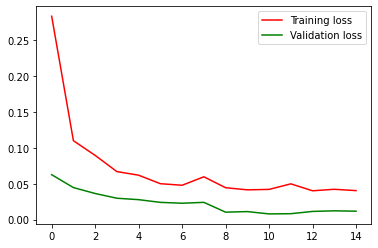

In [13]:
plt.plot(history_lstm.history['loss'], label='Training loss', color='red')
plt.plot(history_lstm.history['val_loss'], label='Validation loss', color= 'green')
plt.legend()
plt.show()

## Predicting

In [15]:
#We want to predict for 70 days
#So, we can change the number of future for prediction
num_future = 70
#To predict time from the last date in dataset: date_col[-1]
predict_dates = pd.date_range(list(date_col)[-1], periods=num_future, freq='1d').tolist()

#Predicting
prediction = model.predict(X_train[-num_future:])
print(prediction[:5])

[[-0.6375535]
 [-0.5683897]
 [-0.6229846]
 [-0.6627502]
 [-0.643865 ]]


In [20]:
#Now, we need to inverse transformation to rescale back to original range
#Here, 5 variables was used for transform
#So, we copy the values 5 times and get rid of them after inverse transform
copy_pred = np.repeat(prediction, values.shape[1], axis=-1)
y_pred = scaler.inverse_transform(copy_pred)[:,0]
print(y_pred[:10])

[12.796801 13.410869 12.92615  12.573093 12.740765 12.578481 12.325375
 12.626179 12.879829 12.934045]


In [21]:
#Read original dataset again
df = pd.read_csv('D:/finance-vix.txt',
                     sep=',',
                     parse_dates=[0],
                     infer_datetime_format=True,
                     index_col=False,
                     na_values=['nan', '?'])

C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

<AxesSubplot:xlabel='Date', ylabel='VIX Open'>

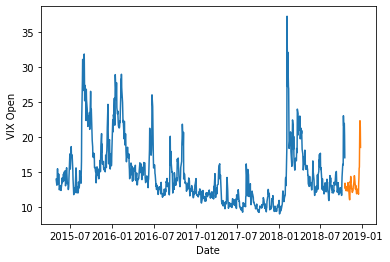

In [22]:
#Convert timestamp to date
pred_date = []
for time_i in predict_dates:
    pred_date.append(time_i.date())
    
df_predict = pd.DataFrame({'Date':np.array(pred_date), 'VIX Open':y_pred})
df_predict['Date'] = pd.to_datetime(df_predict['Date'])

original = df[['Date', 'VIX Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2015-5-1']

sns.lineplot(original['Date'], original['VIX Open'])
sns.lineplot(df_predict['Date'], df_predict['VIX Open'])